In [1]:
import os, json, gc
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.stats import boxcox
from scipy.signal import resample

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error

import lightgbm as lgb
import optuna

import torch
from torch import nn

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.preprocess import EmgEncoder

In [3]:
train = sio.loadmat("../data/train.mat")
test = sio.loadmat("../data/test.mat")
reference = sio.loadmat("../data/reference.mat")

print(reference.keys())

dict_keys(['__header__', '__version__', '__globals__', '0005'])


In [4]:
user_ids = ["0001", "0002", "0003", "0004"]

train_set = []
test_set = []
for i, user_id in enumerate(user_ids):
    train_data = np.load(f"../data/processed/train_{user_id}.npy")
    test_data = np.load(f"../data/processed/test_{user_id}.npy")
    
    train_set.append(train_data)
    test_set.append(test_data)

train_set[0].shape, test_set[0].shape

((319, 1000, 16), (319, 1000, 16))

In [5]:
y_set = [train[user_id][0][0][1].transpose(0, 2, 1) for user_id in user_ids]
y_set[0].shape

(319, 30, 3)

In [6]:
class FullDataset(torch.utils.data.Dataset):
    def __init__(self, x_set: np.ndarray, y_set: np.ndarray, user_ids: list=None):
        super().__init__()
        self.x_set = x_set
        self.y_set = y_set
        
        if user_ids is not None:
            self.user_ids = user_ids
        else:
            self.user_ids = ["0001", "0002", "0003", "0004"]
        
        self.trials = [x.shape[0] for x in self.x_set]
        
    def __len__(self):
        return sum(self.trials)
    
    def __getitem__(self, idx):
        user_idx = 0
        # ユーザーの試行回数に応じてidxを再取得
        while idx >= self.trials[user_idx]:
            idx -= self.trials[user_idx]
            user_idx += 1
        
        x = self.x_set[user_idx][idx]
        y = self.y_set[user_idx][idx][:, 0]
        
        return x, y

train_dataset = FullDataset(train_set, y_set)
x, y = next(iter(train_dataset))
x.shape, y.shape

((1000, 16), (30,))

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(16000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 100, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(100, 30, dtype=torch.float32)
)

In [8]:
batch_size = 1
num_workers = 0
epochs = 30

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

def train_1epoch():
    runnning_loss = 0
    
    for i, data in enumerate(train_loader):
        x, y = data
        optimizer.zero_grad()
        
        output = model(x.to(torch.float32))

        loss = loss_fn(output.to(torch.float32), y.to(torch.float32))
        loss.backward()
        
        optimizer.step()
        
        runnning_loss += loss.item()
    
    return runnning_loss

train_history = []
model.to(device)
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = train_1epoch()
    print(f"[Epoch {epoch}] train loss: {train_loss:.5f}")
    train_history.append(train_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

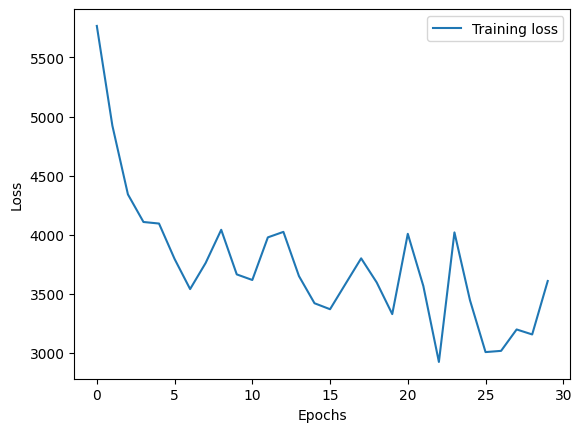

In [27]:
plt.plot(train_history, label="Training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()